In [1]:
# 训练数据
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision

In [23]:
# 超参数
EPOCH = 2
BATCH_SIZE = 64
LR = 0.005
TIME_STEP = 28
INPUT_SIZE = 28
HIDDEN_SIZE = 64
DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root = './mnist/',
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST
)

In [25]:
print('train_data.size():',train_data.train_data.size())
print('train_labels.size():',train_data.train_labels.size())

train_data.size(): torch.Size([60000, 28, 28])
train_labels.size(): torch.Size([60000])


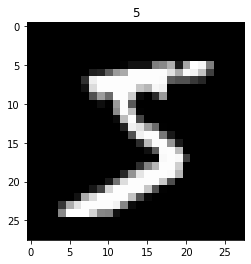

In [27]:
import matplotlib.pyplot as plt
plt.imshow(train_data.train_data[0].numpy(),cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [28]:
# dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle = True)

In [31]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False, transform=torchvision.transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy()[:2000]    # covert to numpy array

In [32]:
print('test_x.size():',test_x.size())
print('test_y.size():',len(test_y))

test_x.size(): torch.Size([2000, 28, 28])
test_y.size(): 2000


In [44]:
class My_LSTM(nn.Module):
    def __init__(self):
        super(My_LSTM,self).__init__()
        
        self.lstm = nn.LSTM(
            input_size = INPUT_SIZE,
            hidden_size = HIDDEN_SIZE,
            num_layers = 1,
            batch_first = True
        )
        
        self.out_projection = nn.Linear(HIDDEN_SIZE,10)
    
    def forward(self,x):
        # x.shape (batch_size,time_step,feature_size)
        # r_out.shape (batch_size,time_step,feature_size)
        # h_n.shape (n_layers,batch_size,hidden_size)
        # h_c.shape (n_layers,batch_size,hidden_size)
        
        r_out,(h_n,h_c) = self.lstm(x,None)
        
        #print('r_out.size() ',r_out.size()) [64,28,64]
        #print('r_out[:,-1,:] size()',r_out[:,-1,:].size()) [64,64]
        # choose r_out at the last time step
        out = self.out_projection(r_out[:,-1,:])
        
        return out

In [45]:
lstm = My_LSTM()
print(lstm)

My_LSTM(
  (lstm): LSTM(28, 64, batch_first=True)
  (out_projection): Linear(in_features=64, out_features=10, bias=True)
)


In [46]:
# 训练
optimizer = torch.optim.Adam(lstm.parameters(),lr=LR)
loss_func = nn.CrossEntropyLoss()

for epoch in range(EPOCH):
    for step,(x,b_y) in enumerate(train_loader):
        b_x = x.view(-1,28,28)
        
        output = lstm(b_x)
        loss = loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            test_output = lstm(test_x)
            pred_y = torch.max(test_output,1)[1].data.numpy()
            accuracy = float((pred_y == test_y).astype(int).sum())/float(test_y.size)
            print('Epoch: ',epoch, ' | train loss : %.4f'%loss.data.numpy(),' | test accuracy:%.2f'%accuracy)

Epoch:  0  | train loss : 2.2988  | test accuracy:0.10
Epoch:  0  | train loss : 0.7164  | test accuracy:0.75
Epoch:  0  | train loss : 0.6076  | test accuracy:0.78
Epoch:  0  | train loss : 0.2944  | test accuracy:0.90
Epoch:  0  | train loss : 0.1424  | test accuracy:0.91
Epoch:  0  | train loss : 0.1521  | test accuracy:0.92
Epoch:  0  | train loss : 0.1535  | test accuracy:0.94
Epoch:  0  | train loss : 0.2166  | test accuracy:0.93
Epoch:  0  | train loss : 0.2239  | test accuracy:0.94
Epoch:  0  | train loss : 0.0572  | test accuracy:0.95
Epoch:  1  | train loss : 0.0572  | test accuracy:0.96
Epoch:  1  | train loss : 0.2013  | test accuracy:0.96
Epoch:  1  | train loss : 0.1844  | test accuracy:0.95
Epoch:  1  | train loss : 0.0642  | test accuracy:0.96
Epoch:  1  | train loss : 0.1748  | test accuracy:0.97
Epoch:  1  | train loss : 0.0180  | test accuracy:0.96
Epoch:  1  | train loss : 0.1462  | test accuracy:0.95
Epoch:  1  | train loss : 0.1074  | test accuracy:0.96
Epoch:  1 

In [36]:
# print 10 predictions from test data
test_output = lstm(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
